In [3]:
import os 
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

# launch this cell if you have issues on windows with py4j (think about updating your PATH)
import sys
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

# starts a spark session from notebook

os.environ['PYSPARK_SUBMIT_ARGS'] ="--conf spark.driver.memory=4g  pyspark-shell"
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("load_explore") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/26 09:28:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/26 09:28:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/05/26 09:28:28 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [4]:
item_features = spark.read.load('../Data/item_features.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

## exploration

In [6]:
item_features.printSchema()

root
 |-- item_id: integer (nullable = true)
 |-- feature_category_id: integer (nullable = true)
 |-- feature_value_id: integer (nullable = true)



In [10]:
for column in item_features.columns:
    print(f'{column} has {item_features.select(column).distinct().count()} unique elements')

item_id has 23691 unique elements
feature_category_id has 73 unique elements
feature_value_id has 890 unique elements


In [25]:
unique_categories = item_features.select('feature_category_id').distinct().rdd.flatMap(lambda x: x).collect()

print(unique_categories)


[31, 65, 53, 34, 28, 26, 44, 12, 22, 47, 1, 52, 13, 16, 6, 3, 20, 40, 57, 54, 48, 5, 19, 64, 41, 15, 43, 37, 61, 17, 9, 72, 35, 55, 59, 4, 8, 39, 23, 49, 7, 51, 69, 63, 10, 50, 45, 38, 73, 25, 24, 70, 62, 29, 21, 32, 60, 56, 58, 33, 11, 68, 71, 14, 42, 2, 30, 66, 46, 67, 18, 36, 27]


In [34]:
item_features.filter(item_features.feature_category_id == 1)

DataFrame[item_id: int, feature_category_id: int, feature_value_id: int]

In [44]:
per_category_count = 0
for category in unique_categories:
    sub = item_features.filter(item_features.feature_category_id == category).distinct()
    sub_feature = sub.select('feature_value_id').distinct()
    sub_item = sub.select('item_id').distinct()
    per_category_count += sub_feature.count()
    print(f'category = {category}, unique item count = {sub_item.count()}, number of unique feature = {sub_feature.count()}')
    #sub_feature.show()
print(f'total number of cumulated features = {per_category_count}, VS 890')

category = 31, unique item count = 2567, number of unique feature = 4
category = 65, unique item count = 10960, number of unique feature = 11
category = 53, unique item count = 3790, number of unique feature = 5
category = 34, unique item count = 7033, number of unique feature = 4
category = 28, unique item count = 1774, number of unique feature = 6
category = 26, unique item count = 14270, number of unique feature = 21
category = 44, unique item count = 3775, number of unique feature = 27
category = 12, unique item count = 1565, number of unique feature = 6
category = 22, unique item count = 608, number of unique feature = 3
category = 47, unique item count = 23691, number of unique feature = 17
category = 1, unique item count = 939, number of unique feature = 6
category = 52, unique item count = 568, number of unique feature = 5
category = 13, unique item count = 137, number of unique feature = 4
category = 16, unique item count = 1881, number of unique feature = 4
category = 6, uniq

almost no overlap vetween feature(value) and category --> let's one hot encode on the value and do some clustering (2_category_feature_engineer.ipynb)

## RDD pipeline for feature value clustering

In [4]:
item_features = spark.read.load('../Data/item_features.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

# GOAL : ONE HOT ENCODE ALL DIFFERENT FEATURES VALUE 

features_count = item_features.rdd.map(lambda x: str(x[2])+"_"+str(x[1])).distinct().collect() # 904 different features value
renamed_set = item_features.rdd.map(lambda x: (x[0], str(x[2])+"_"+str(x[1])))

dic_values = {elem:i for i, elem in enumerate(features_count)} # maps the features values in a dictionnary

def fill_column(x):
    value = dic_values.get(x[1])
    return (x[0],((0,)*(value)+(1,)+(0,)*(len(features_count)-value-1)))
columns_features = renamed_set.map(fill_column) # creates all empty columns with features values and fills it
reduced_map = columns_features.reduceByKey(lambda x,y : tuple(sum(x) for x in zip(x,y))) # reduce by key (item)

dataset = reduced_map.map(lambda x : x[1]) # remap everything in one single line of 904 elements (easier for clustering)

In [11]:
item_features = spark.read.load('../Data/item_features.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

# GOAL : ONE HOT ENCODE ALL DIFFERENT FEATURES VALUE 

category_count = item_features.rdd.map(lambda x: x[1]).distinct().collect() # 904 different features value
renamed_set = item_features.rdd.map(lambda x: (x[0], x[1]))

dic_values = {elem:i for i, elem in enumerate(category_count)} # maps the features values in a dictionnary

def fill_column(x):
    value = dic_values.get(x[1])
    return (x[0],((0,)*(value)+(1,)+(0,)*(len(category_count)-value-1)))
columns_features = renamed_set.map(fill_column) # creates all empty columns with features values and fills it
reduced_map = columns_features.reduceByKey(lambda x,y : tuple(sum(x) for x in zip(x,y))) # reduce by key (item)

dataset = reduced_map.map(lambda x : x[1]) # remap everything in one single line of 904 elements (easier for clustering)

#### Clustering with map/reduce

In [14]:
##### CLUSTERING WITH MAP/REDUCE
# inspired from https://uv.ulb.ac.be/pluginfile.php/3410436/mod_resource/content/1/Kmeans.html?fbclid=IwAR1h5xJKxQ1nrCHlgtQsofwjgc8B7oVl69GG6Mm8WxChTH3zBc4SKFo3Noo
###nb : si tu as un dataset avec une key fais juste un remapping pour l'enlever du dataset_ = dataset.rdd.map(lambda x: (x[1,:]))

from pyspark.context import SparkContext
sc = SparkContext.getOrCreate()

def mapstep(x,br_clusters): 
    """
    This function returns the closest cluster of the current row x
    x : current row
    broadcast_clusters : current value of the clusters
    """
    M = br_clusters.value.shape[0]
    d=np.zeros(M) # distance of the current row with each cluster
    for m in range(M):
        d[m]=sum(abs(np.subtract(x,br_clusters.value[m]))) # compute distance between cluster m and row x
    return(np.argmin(d),)    

def k_means_MR(dataset,M,steps):
    """
    dataset : RDD data structure, all columns are used for distance computation (1xn dimension)
    M : number of clusters
    steps : number of steps
    """
    n = len(dataset.take(1)[0]) # input dimension
    clusters = np.array(dataset.takeSample(True,M)) # starts with random clusters
    broadcast_clusters = sc.broadcast(clusters) ## broadcast cluster position
    for i in range(steps):
        distance_set = dataset.map(lambda x : mapstep(x,broadcast_clusters)+(x+(1,),)) # set containing (closest_cluster,(row value),counter=1)
        new_clusters_set = distance_set.reduceByKey(lambda x,y : np.add(x,y)) # adds all cluster related entry (+ increments counter)
        new_clusters_set = new_clusters_set.map(lambda x : x[1][:-1]/x[1][-1]) # apply mean operation
        new_clusters = np.array(new_clusters_set.take(M))
        broadcast_clusters = sc.broadcast(new_clusters)
    return broadcast_clusters.value


clusters = k_means_MR(dataset,50,5) # compute cluster values

broadcast_clusters = sc.broadcast(clusters) # broadcasting is a good practice for parallel computing
clustered_set = reduced_map.map(lambda x : (x[0],)+mapstep(x[1],broadcast_clusters)) # compute associated clusters for each item

clustered_set.take(20) # (example) OUTPUT [ITEM_ID | CLUSTER_ID]

[(2, 0),
 (4, 18),
 (8, 1),
 (10, 2),
 (14, 19),
 (16, 18),
 (18, 20),
 (20, 3),
 (24, 4),
 (26, 21),
 (28, 22),
 (30, 19),
 (32, 5),
 (36, 21),
 (38, 6),
 (40, 23),
 (42, 4),
 (44, 22),
 (46, 7),
 (50, 18)]

#### Clustering with MLLIB

In [10]:
######## CLUSTERING WITH MLLIB

from pyspark.mllib.clustering import KMeans, KMeansModel

WSSSE_list = []

for i in range(1,2):
    print(i*5)
    WSSSE_temp = 0
    for j in range(1): # averaged on 2 runs
        # Build the model (cluster the data)
        clusters = KMeans.train(dataset, i*240, maxIterations=20, initializationMode="random")

        # Evaluate clustering by computing Within Set Sum of Squared Errors
        def error(point):
            center = clusters.centers[clusters.predict(point)]
            return np.sqrt(sum([x**2 for x in (point - center)]))

        WSSSE = dataset.map(lambda point: error(point)).reduce(lambda x, y: x + y)

        #print("Within Set Sum of Squared Error = " + str(WSSSE) + " for n = " + str(i))
        
        WSSSE_temp += WSSSE
    
    WSSSE_list.append(WSSSE_temp/2)

5


22/05/24 19:22:47 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/24 19:22:47 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


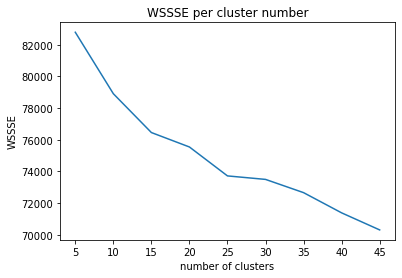

In [343]:
import matplotlib.pyplot as plt
x = np.arange(5,50,5)

plt.plot(x, WSSSE_list) 
plt.xlabel('number of clusters')
plt.ylabel('WSSSE')
plt.title('WSSSE per cluster number')
plt.show()

_______________________________________________________________________________________

In [11]:
# 23691 items / 25 clusters = ~850 --> good dimension reduction
#clusters = KMeans.train(dataset, 25, maxIterations=30, initializationMode="random")

clustered_dataset = reduced_map.map(lambda x : (x[0], clusters.predict(x[1]))) # remap everything in one single line of 890 + 1 elements (easier for clustering)

In [12]:
clustered_dataset.take(10)

[(2, 136),
 (4, 104),
 (8, 152),
 (10, 174),
 (14, 210),
 (16, 104),
 (18, 211),
 (20, 1),
 (24, 112),
 (26, 226)]

In [ ]:
clustered_dataset.toDF().repartition(1).write.csv('250_clustered_features.csv')


The resulting data set (clustered_dataset) has two columns : [item_id, cluster_id]

array([[<AxesSubplot:title={'center':'_2'}>]], dtype=object)

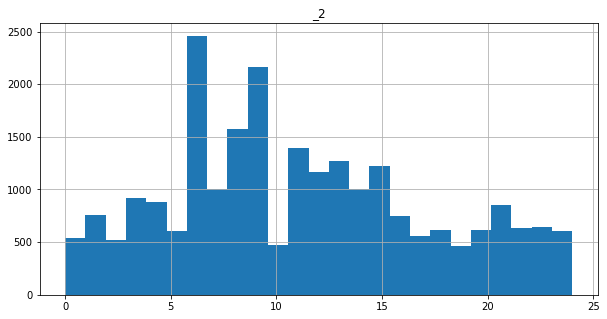

In [356]:
clustered_df = clustered_dataset.toDF().toPandas()
clustered_df.hist(column='_2',bins=25, figsize=(10,5))

In [353]:
clustered_df['_2'].value_counts() # number of element per cluster

6     2458
9     2162
8     1579
11    1394
13    1275
15    1222
12    1165
7     1004
14    1003
3      918
4      882
21     851
1      758
16     750
23     640
22     635
18     616
20     615
24     607
5      606
17     554
0      541
2      519
10     474
19     463
Name: _2, dtype: int64